In [1]:
import pandas as pd
from fractions import Fraction
from empiricaldist import Pmf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

In [66]:
from scipy.stats import poisson

lam = 1.4
dist = poisson(lam)

In [69]:
k = 4
dist.pmf(k)

0.039471954028253146

In [70]:
def make_poisson_pmf(lam, qs):
    """Make a Pmf of a Poisson distribution."""
    ps = poisson(lam).pmf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [71]:
lam = 1.4
goals = np.arange(10)
pmf_goals = make_poisson_pmf(lam, goals)

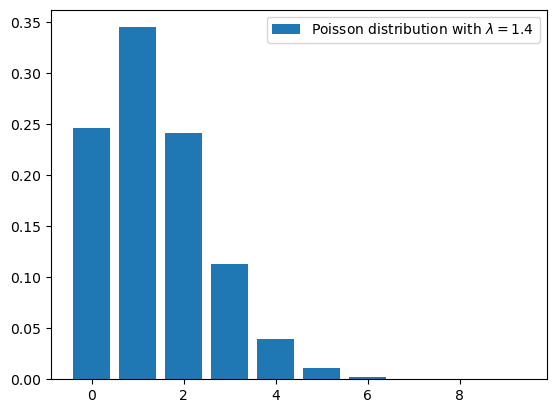

In [72]:
pmf_goals.bar(label=r'Poisson distribution with $\lambda=1.4$')
plt.legend();

In [73]:
from scipy.stats import gamma

alpha = 1.4
qs = np.linspace(0, 10, 101)
ps = gamma(alpha).pdf(qs)

prior = Pmf(ps, qs)
prior.normalize()

9.889360237140306

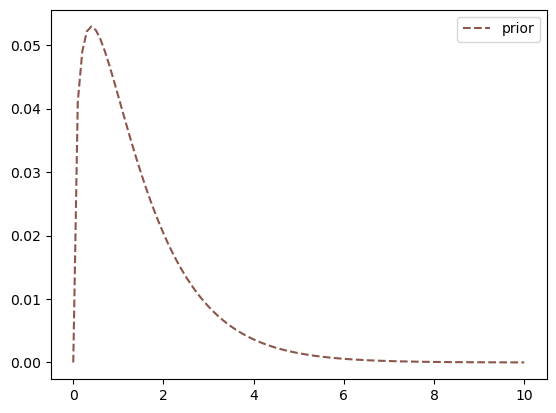

In [74]:
prior.plot(ls='--', label='prior', color='C5')
plt.legend();

In [75]:
lam = 1.4
k = 4
poisson(lam).pmf(4)

0.039471954028253146

In [77]:
lams = prior.qs
k = 4
likelihood = poisson(lams).pmf(k)

In [79]:
def update_poisson(pmf, k):
    """Update Pmf with a Poisson likelihood."""
    lams = pmf.qs
    likelihood = poisson(lams).pmf(k)
    pmf *= likelihood
    pmf.normalize()

In [80]:
france = prior.copy()
update_poisson(france, 4)

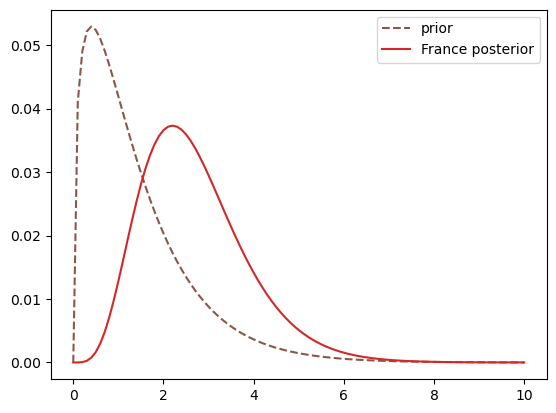

In [81]:
prior.plot(ls='--', label='prior', color='C5')
france.plot(label='France posterior', color='C3')

plt.legend();

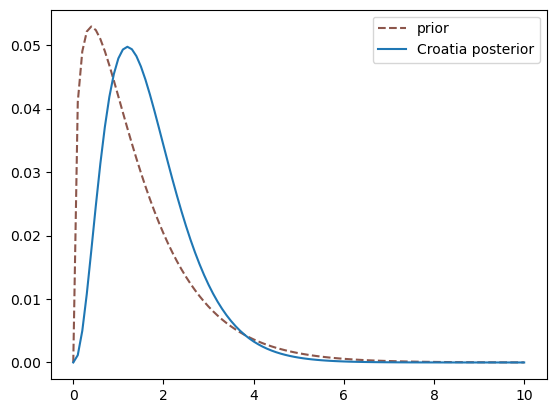

In [82]:
croatia = prior.copy()
update_poisson(croatia, 2)

prior.plot(ls='--', label='prior', color='C5')
croatia.plot(label='Croatia posterior', color='C0')

plt.legend();

In [83]:
print(croatia.mean(), france.mean())

1.6999765866755225 2.699772393342308


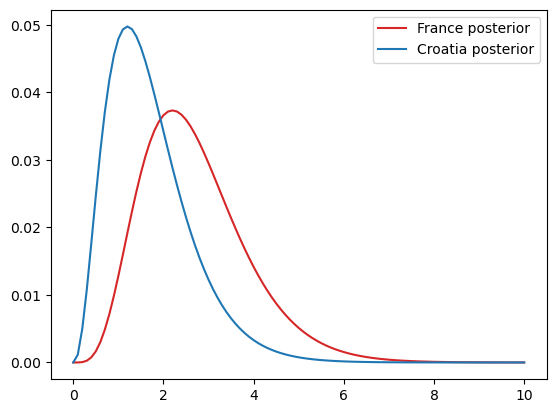

In [84]:
france.plot(label='France posterior', color='C3')
croatia.plot(label='Croatia posterior', color='C0')

plt.legend();

In [85]:
def prob_gt(pmf1, pmf2):
    """Compute the probability of superiority."""
    total = 0
    for q1, p1 in pmf1.items():
        for q2, p2 in pmf2.items():
            if q1 > q2:
                total += p1 * p2
    return total

In [86]:
prob_gt(france, croatia)

0.7499366290930155

In [87]:
Pmf.prob_gt(france, croatia)

0.7499366290930174

In [89]:
pmf_seq = [make_poisson_pmf(lam, goals) 
           for lam in prior.qs]

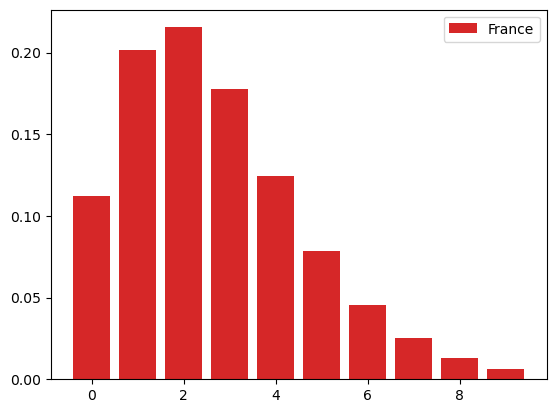

In [91]:
from utils import make_mixture

pred_france = make_mixture(france, pmf_seq)
pred_france.bar(color='C3', label='France')

plt.legend();

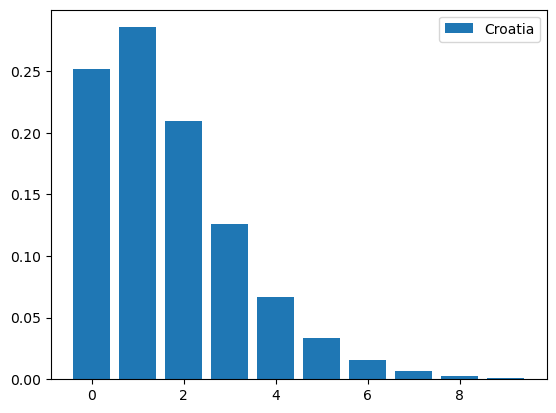

In [94]:
pred_croatia = make_mixture(croatia, pmf_seq)

pred_croatia.bar(color='C0', label='Croatia')
plt.legend();

In [95]:
win = Pmf.prob_gt(pred_france, pred_croatia)
tie = Pmf.prob_eq(pred_france, pred_croatia)
lose = Pmf.prob_lt(pred_france, pred_croatia)

In [96]:
win + tie*win

0.664582414460093

In [111]:
def expo_pdf(t, lam):
    """Compute the PDF of the exponential distribution."""
    return lam * np.exp(-lam * t)

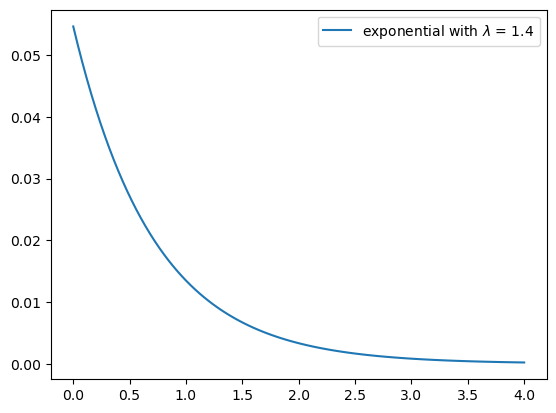

In [114]:
lam = 1.4
qs = np.linspace(0, 4, 101)
ps = expo_pdf(qs, lam)
pmf_time = Pmf(ps, qs)
pmf_time.normalize()

pmf_time.plot(label='exponential with $\lambda$ = 1.4')
plt.legend();

## FIFA

In [99]:
prior

,probs
0.0,0.000000
0.1,0.041053
0.2,0.049015
0.3,0.052160
0.4,0.052952
...,...
9.6,0.000019
9.7,0.000017
9.8,0.000016
9.9,0.000014


In [120]:
def update_expo(pmf, data):
    t = data / 90
    lams = pmf.qs
    likelihood = expo_pdf(t, lams)
    pmf *= likelihood
    pmf.normalize()

In [121]:
germany = prior.copy()
update_expo(germany, 11)

germany2 = germany.copy()
update_expo(germany2, 12)

In [123]:
germany2.mean()

2.703059034926364

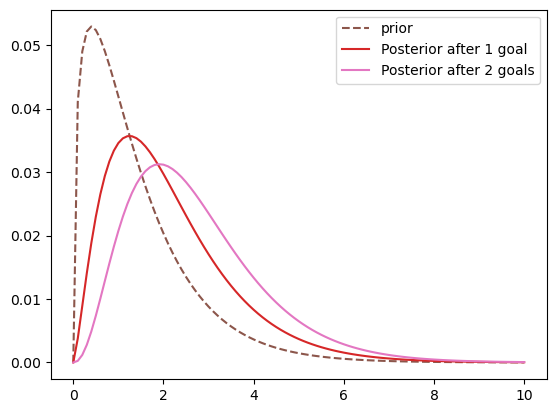

In [124]:
prior.plot(ls='--', label='prior', color='C5')
germany.plot(color='C3', label='Posterior after 1 goal')
germany2.plot(color='C16', label='Posterior after 2 goals')

plt.legend();

In [127]:
t = (90-23) / 90

pmf_seq = [make_poisson_pmf(lam*t, goals) 
           for lam in germany2.qs]

In [133]:
pred_germany2 = make_mixture(germany2, pmf_seq)

In [135]:
croatia

,probs
0.0,0.000000e+00
0.1,1.154111e-03
0.2,4.987243e-03
0.3,1.080490e-02
0.4,1.764472e-02
...,...
9.6,3.699161e-07
9.7,3.104885e-07
9.8,2.605416e-07
9.9,2.185748e-07


In [136]:
def make_expo_pmf(lam, high):
    """Make a PMF of an exponential distribution.
    
    lam: event rate
    high: upper bound on the interval `t`
    
    returns: Pmf of the interval between events
    """
    qs = np.linspace(0, high, 101)
    ps = expo_pdf(qs, lam)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [137]:
pmf_seq = [make_expo_pmf(lam, high=4) for lam in prior.qs]

pred_france = make_mixture(france, pmf_seq)
pred_croatia = make_mixture(croatia, pmf_seq)

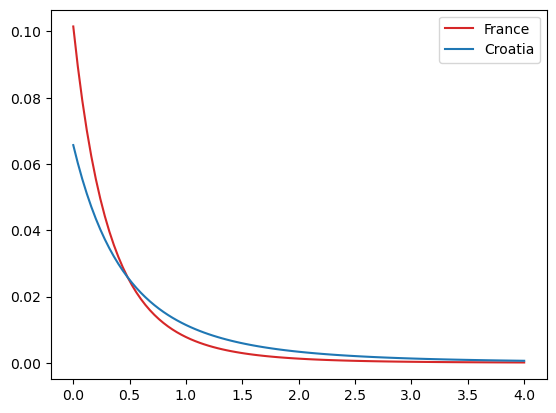

In [138]:
pred_france.plot(label='France', color='C3')
pred_croatia.plot(label='Croatia', color='C0')

plt.legend();

In [139]:
from scipy.stats import gamma

alpha = 2.8
qs = np.linspace(0, 15, 101)
ps = gamma.pdf(qs, alpha)
prior_hockey = Pmf(ps, qs)
prior_hockey.normalize()

6.666325137469514

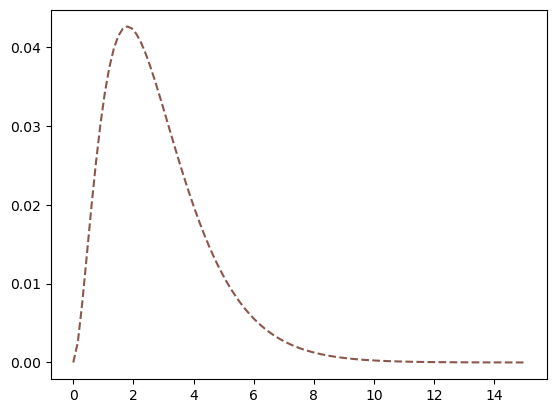

In [141]:
prior_hockey.plot(ls='--', color='C5');

In [142]:
bruins = prior_hockey.copy()
for data in [0, 2, 8, 4]:
    update_poisson(bruins, data)

canucks = prior_hockey.copy()
for data in [1, 3, 1, 0]:
    update_poisson(canucks, data)

bruins.mean(), canucks.mean()

(3.3599999999999985, 1.5599999606443666)

In [ ]:
goals = np.arange(15)
pmf_seq = [make_poisson_pmf(lam, goals) for lam in bruins.qs]